## 使用VAE來做手寫辨識，將最後的結果動態呈現出來，打造最好的呈現方式!
想想在encoder找到兩張手寫數字 a, b 的 latent representation，  
然後從代表 a 的 latent 到代表 b 的 latent 拉一直線，  
把線段中代表的圖用 decoder 畫出來，這個必須是動態的圖片變化，可參考上禮拜上課呈現出來中間那張圖的樣子

*模型權重可使用澤佑助教提供的

In [1]:
%env KERAS_BACKEND = tensorflow

env: KERAS_BACKEND=tensorflow


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, FloatSlider

In [3]:
# Keras functions
from keras.models import Sequential, Model
from keras.layers import Input, Lambda, concatenate
from keras.layers import Dense
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv2DTranspose, UpSampling2D
from keras.optimizers import SGD, Adam
from keras import metrics

# Keras dataset
from keras.datasets import mnist

# Keras utilis function
from keras.utils import np_utils

from keras import backend as K

Using TensorFlow backend.


### 讀MNIST資料並且攤平

In [4]:
(x_train0, y_train0), (x_test0, y_test0) = mnist.load_data()

x_train = x_train0.reshape(60000, -1)
x_test = x_test0.reshape(10000, -1)

x_train -= x_train.min()
x_train = x_train/x_train.max()

### VAE

In [5]:
enc_1 = Dense(100, activation = 'sigmoid')
enc_2 = Dense(10, activation = 'sigmoid')

enc_mean = Dense(2)
enc_log_var = Dense(2)

dec_2 = Dense(100, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')

In [6]:
x = Input(shape=(784,))
enc_x = enc_1(x)
enc_x = enc_2(enc_x)

z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

定義抽樣函數

In [7]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(2,), mean=0., stddev=1)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [8]:
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

In [9]:
dec_x = dec_2(z)
x_hat = dec_1(dec_x)

In [10]:
VAE = Model(x, x_hat)
VAE.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          78500       input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 10)           1010        dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            22          dense_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (D

### Loss 函數的建立

In [11]:
def vae_loss(x, x_recon):  
    recovery_loss = 784 * metrics.binary_crossentropy(x, x_recon)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return recovery_loss + kl_loss

In [12]:
VAE.compile(loss = vae_loss, optimizer = Adam())

In [13]:
VAE.fit(x_train, x_train, batch_size=32, epochs=10)

Epoch 1/10
60000/60000 [==============================] - 6s 103us/step - loss: 202.1104
Epoch 2/10
60000/60000 [==============================] - 5s 81us/step - loss: 188.8765
Epoch 3/10
60000/60000 [==============================] - 5s 81us/step - loss: 179.8787
Epoch 4/10
60000/60000 [==============================] - 5s 81us/step - loss: 177.1017
Epoch 5/10
60000/60000 [==============================] - 5s 82us/step - loss: 172.8611
Epoch 6/10
60000/60000 [==============================] - 5s 82us/step - loss: 169.2279
Epoch 7/10
60000/60000 [==============================] - 5s 82us/step - loss: 166.6716
Epoch 8/10
60000/60000 [==============================] - 5s 83us/step - loss: 164.8611
Epoch 9/10
60000/60000 [==============================] - 5s 83us/step - loss: 163.4102
Epoch 10/10
60000/60000 [==============================] - 5s 83us/step - loss: 161.9562


### 視覺化呈現

In [14]:
VAE_Encoder = Model(x, z_mean)

VAE_Encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 22        
Total params: 79,532
Trainable params: 79,532
Non-trainable params: 0
_________________________________________________________________


In [15]:
h_input = Input(shape = (2,))
VAE_Decoder = Model(h_input, dec_1(dec_2(h_input)))

VAE_Decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_6 (Dense)              (None, 784)               79184     
Total params: 79,484
Trainable params: 79,484
Non-trainable params: 0
_________________________________________________________________


In [16]:
idx = np.random.randint(x_train.shape[0])
print("第 %d 圖的 latent 表示為 %s" %(idx, VAE_Encoder.predict(x_train[idx: idx+1])))

第 15025 圖的 latent 表示為 [[0.05613366 1.2027305 ]]


In [17]:
indices = np.random.randint(x_test.shape[0], size = 1000)
VAE_latents = VAE_Encoder.predict(x_test[indices])

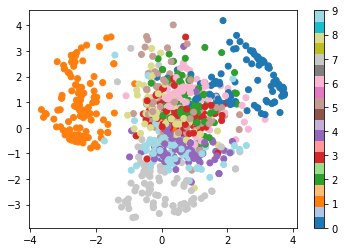

In [18]:
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c = y_test0[indices], cmap = 'tab20')
plt.colorbar()
plt.show()

In [19]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [20]:
n =15
digit_size = 28

grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)

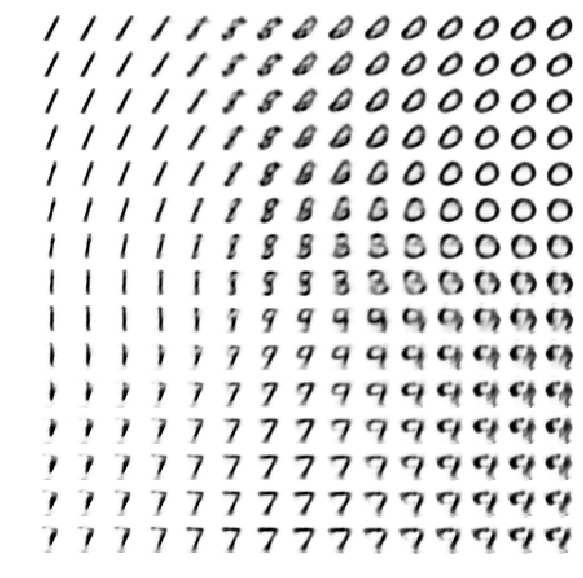

In [21]:
plt.figure(figsize=(10, 10))
plt.imshow(VAE_figure, cmap='Greys')
plt.axis('off')
plt.show()

### 動態比較

In [22]:
def inBetween(t):
    data_0 = x_train0[idx_1]
    data_1 = x_train0[idx_2]
    data_t = (1 - t) * x_train0[idx_1] + t * x_train0[idx_2]

    mu_0 = VAE_Encoder.predict(x_train[idx_1:idx_1 + 1]).squeeze()
    mu_1 = VAE_Encoder.predict(x_train[idx_2:idx_2 + 1]).squeeze()
    mu_t = (1-t) * mu_0 + t * mu_1

    plt.figure(figsize = (10, 5))
    ax1 = plt.subplot(2, 1, 2)
    ax1.scatter(mu_0[0], mu_0[1])
    ax1.scatter(mu_1[0], mu_1[1])
    ax1.scatter(mu_t[0], mu_t[1])

    ax2 = plt.subplot(2, 3, 1)
    ax2.imshow(data_0, cmap = 'Greys')

    ax3 = plt.subplot(2, 3, 2)
    ax3.imshow(data_t, cmap = 'Greys')

    ax4 = plt.subplot(2, 3, 3)
    ax4.imshow(data_1, cmap = 'Greys')

In [23]:
idx_1, idx_2 = np.random.randint(x_test.shape[0], size = 2)
data_0 = x_train0[idx_1]
data_1 = x_train0[idx_2]


In [24]:
interact(inBetween, t=FloatSlider(value = 0.5, 
                                  min = 0, 
                                  max = 1.0,
                                  step = 0.02,))

interactive(children=(FloatSlider(value=0.5, description='t', max=1.0, step=0.02), Output()), _dom_classes=('w…

<function __main__.inBetween(t)>